In [1]:
import pandas as pd
import numpy as np
from pandas import Series
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from collections import Counter
from pandas.tseries.offsets import BDay
import calendar
from itertools import product
import math

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

import datetime as dt
from datetime import datetime, date, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller    ## ADF test
from statsmodels.tsa.stattools import kpss     ## KPSS test

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
revenue = pd.read_excel('SARIMA Data - Frances.xlsx','Partner_S')
# first order difference
revenue['rev_1st_diff'] = revenue['Partner_S'].diff()

# second order difference
revenue['rev_2nd_diff'] = revenue['Partner_S'].diff(periods=2)

training = revenue[revenue['year'] <= 2020]
forecast = revenue[revenue['year'] == 2021]
forecast[:1]

,year,month,Partner_S,rev_1st_diff,rev_2nd_diff
75,2021,January,449643.0,-182445.0,-176240.0


### ADF & KPSS test
-  to test whether the process is stationary 
-  result shows that the revenue data is not stationary(has a root), so we differencing the data and test again. This time it shows stationary

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [3]:
## ADF test
## H_0: trend is not stationary (has a root)
## H_1: trend is stationary
print("Results of Dickey-Fuller Test:")
adf_test = adfuller(list(training["rev_1st_diff"][2:75]), autolag='AIC')
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','# lags','# observations'])
for key, value in adf_test[4].items():
    adf_output['Critical Value (%s)' %key] = value
print(adf_output)


Results of Dickey-Fuller Test:
Test Statistic         -9.126766e+00
p-value                 3.098557e-15
# lags                  1.000000e+00
# observations          7.100000e+01
Critical Value (1%)    -3.526005e+00
Critical Value (5%)    -2.903200e+00
Critical Value (10%)   -2.588995e+00
dtype: float64


In [4]:
## KPSS test
## H_0: trend is stationary
## H_1: trend is not stationary (has a root)
print('Results of KPSS Test:')
kpss_test = kpss(list(training['rev_1st_diff'][2:75]),regression='c',nlags='auto')
kpss_output= pd.Series(kpss_test[0:3], index=["Test Statistic", "p-value", "Lags Used"])
for key, value in kpss_test[3].items():
    kpss_output['Critical Value (%s)' % key] = value
print(kpss_output)


Results of KPSS Test:
Test Statistic            0.500000
p-value                   0.041667
Lags Used                72.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### plot ACF & PACF (partial autocorrelation function)
-  using differencing data to plot
-  both ACF and PACF are tail off, use ARIMA model

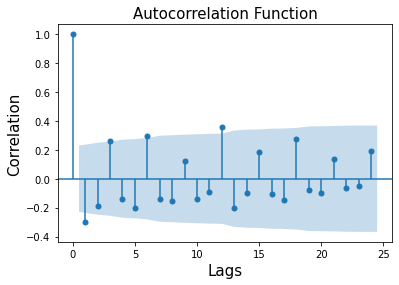

In [5]:
plot_acf(training['rev_1st_diff'][2:75], lags=24)
plt.title("Autocorrelation Function", fontsize=15)
plt.xlabel("Lags",fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.show()


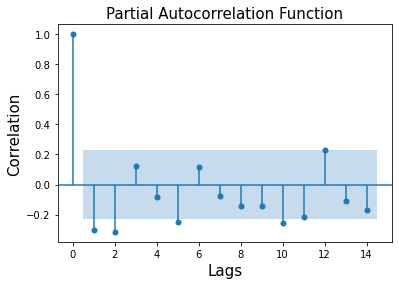

In [6]:
plot_pacf(training['rev_1st_diff'][2:75], lags=14)
plt.title("Partial Autocorrelation Function", fontsize=15)
plt.xlabel("Lags",fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.show()

### SARIMAX Parameter Optimizer

In [7]:
# define function
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
# calculate optimized parameter combination
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [9]:
# find the one with lowest AIC
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, training['Partner_S'])
result_df

,"(p,q)x(P,Q)",AIC
0,"(0, 1, 0, 1)",1565.826436
1,"(2, 0, 0, 1)",1566.191167
2,"(0, 1, 0, 2)",1567.541932
3,"(0, 1, 1, 1)",1567.613987
4,"(0, 2, 0, 1)",1567.693175
...,...,...
251,"(3, 3, 0, 0)",1584.093470
252,"(1, 3, 0, 0)",1584.610781
253,"(2, 2, 0, 0)",1584.984920
254,"(3, 1, 0, 0)",1584.995295


### SARIMAX model
-  find an optimal combination of p,d,q,s that gives minimum MSE

In [10]:
best_model = SARIMAX(training['Partner_S'], order=(2, 1, 0), seasonal_order=(0, 2, 1, 12)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Partner_S   No. Observations:                   75
Model:             SARIMAX(2, 1, 0)x(0, 2, [1], 12)   Log Likelihood                -648.682
Date:                              Thu, 27 Jan 2022   AIC                           1305.365
Time:                                      15:52:20   BIC                           1313.013
Sample:                                           0   HQIC                          1308.277
                                               - 75                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3507      0.257     -1.367      0.172      -0.853       0.152
ar.L2         -0.14

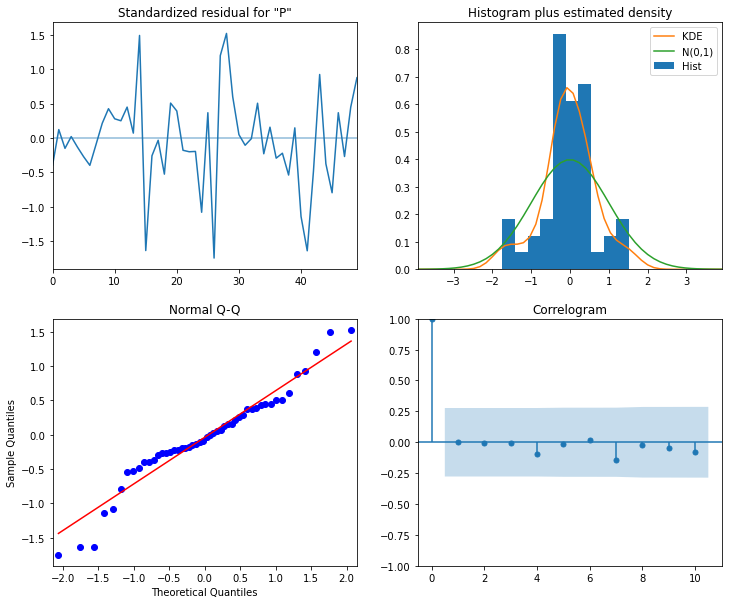

In [11]:
# plot the residuals:
best_model.plot_diagnostics(figsize=(12,10));

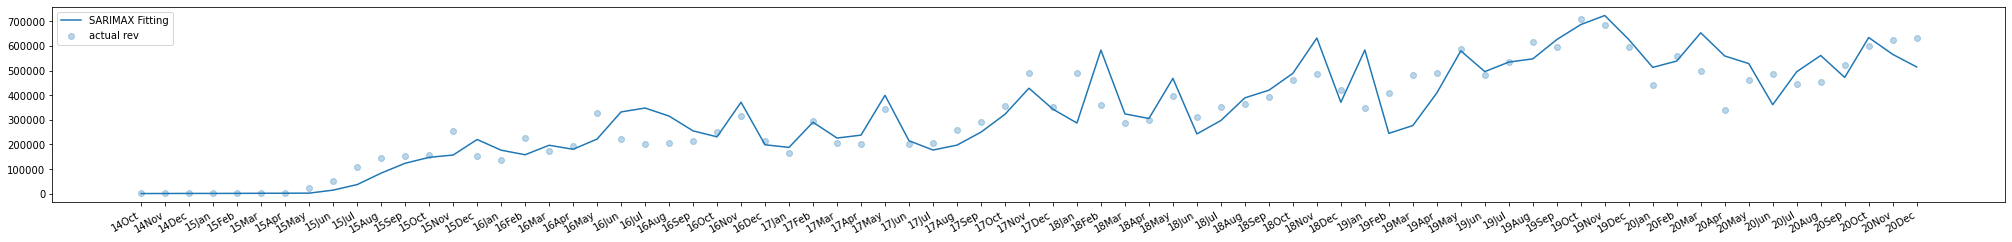

In [12]:
# SARIMAX fitting plot
x = training['year'].astype(str).str[-2:] + training['month'].str[:3]
y_actual = training['Partner_S']
model_fit = best_model.fittedvalues
y_fitting = model_fit.tolist()

fig, ax = plt.subplots()
ax.scatter(x, y_actual, alpha=0.3, label = 'actual rev')
ax.plot(x, y_fitting, label = 'SARIMAX Fitting')
ax.legend(loc='best')
fig.set_figwidth(35)
fig.autofmt_xdate()

### Month over Month Predictions

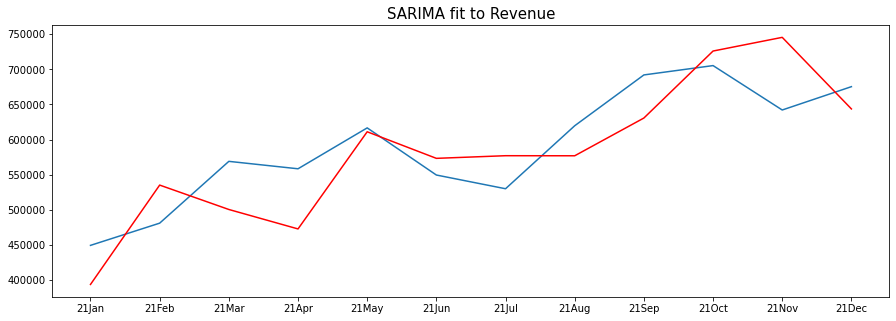

In [15]:
# SARIMAX model

x = forecast['year'].astype(str).str[-2:] + forecast['month'].str[:3]
actual_data = forecast['Partner_S']

prediction = []
update_model = best_model
for i in range(12):
    model_predict = update_model.predict(start=training.shape[0]+i, end=training.shape[0]+i)
    prediction += model_predict.tolist()
    training_update = training.append(forecast[:i+1])
    update_model = SARIMAX(training_update['Partner_S'], order=(2, 1, 0), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)

plt.figure(figsize=(15,5))
plt.plot(x, actual_data)
plt.plot(x, prediction, color='red')
plt.title("SARIMA fit to Revenue",fontsize=15)
plt.xticks()
plt.show()

In [14]:
mse = mean_squared_error(actual_data, prediction)
rmse = math.sqrt(mse)
percent_of_error = rmse/actual_data.mean()*100
print('percent_of_error:',percent_of_error,'%')

percent_of_error: 9.588454112950526 %
